In [20]:
import tensorflow as tf
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow_datasets as tfds



In [21]:
train_ds, train_metadata = tfds.load(
    'Food101',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    batch_size=128,
    with_info=True
    )
val_ds, val_metadata = tfds.load(
    'Food101',
    split='validation',
    shuffle_files=True,
    as_supervised=True,
    batch_size=128,
    with_info=True
    )

In [22]:
print(train_metadata.features["label"].num_classes)
print(train_metadata.features["label"].names)

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso

In [23]:
sample_data = list(train_ds.take(1))

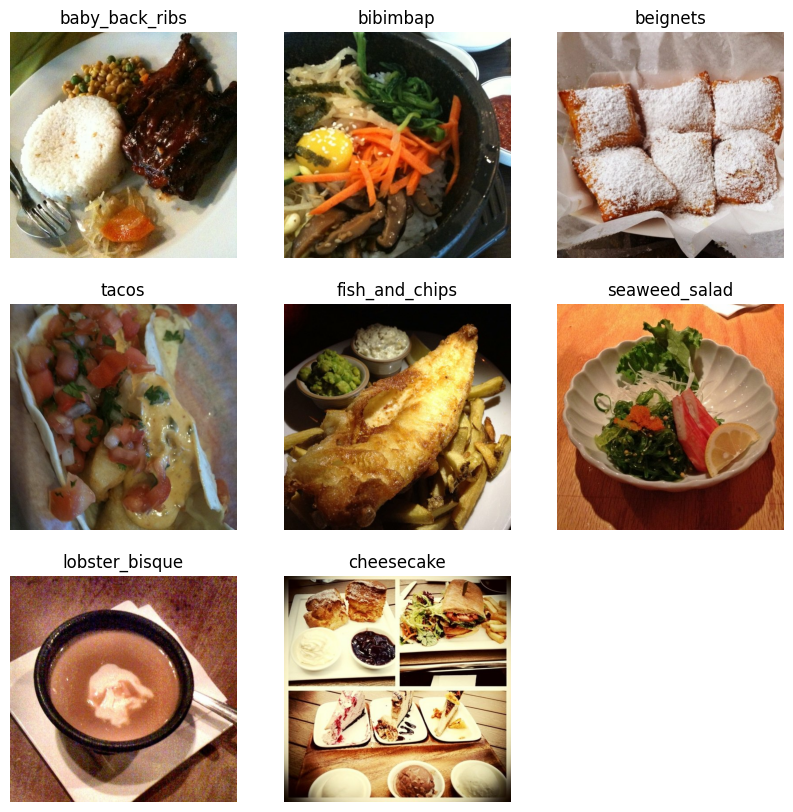

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

In [25]:
from tqdm import tqdm

data_info = {
    class_name: 0
    for class_name in train_metadata.features["label"].names
}
for _, label in tqdm(train_ds):
  for value in label:
    class_id = int(value)
    class_name = train_metadata.features["label"].int2str(class_id)
    data_info[class_name] += 1

100%|██████████| 592/592 [03:50<00:00,  2.56it/s]


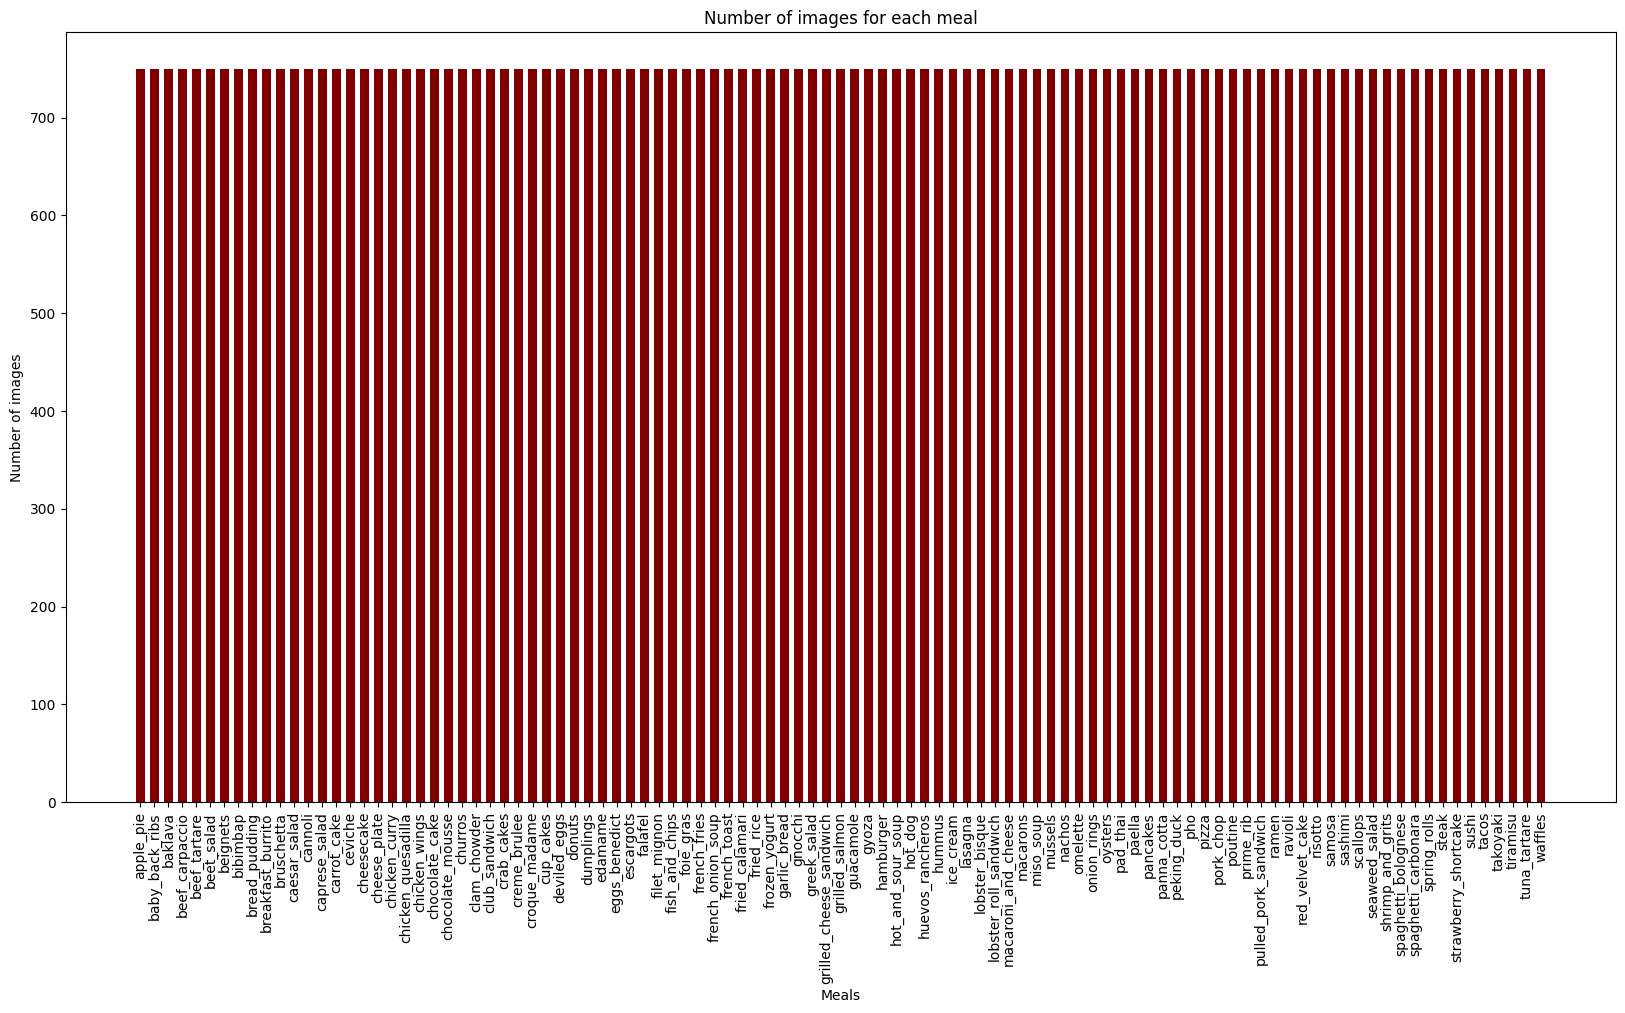

In [26]:
meals = list(data_info.keys())
number_of_images = list(data_info.values())

fig = plt.figure(figsize = (20, 10))

# creating the bar plot
plt.bar(meals, number_of_images, color ='maroon',
        width = 0.6)

# Rotation of the bars names
plt.xticks(range(len(meals)), meals, rotation='vertical')

plt.xlabel("Meals")
plt.ylabel("Number of images")
plt.title("Number of images for each meal")
plt.show()

In [27]:
IMAGE_SIZE = (256, 256)
L1_LAMBDA = 1e-4
L2_LAMBDA = 1e-4

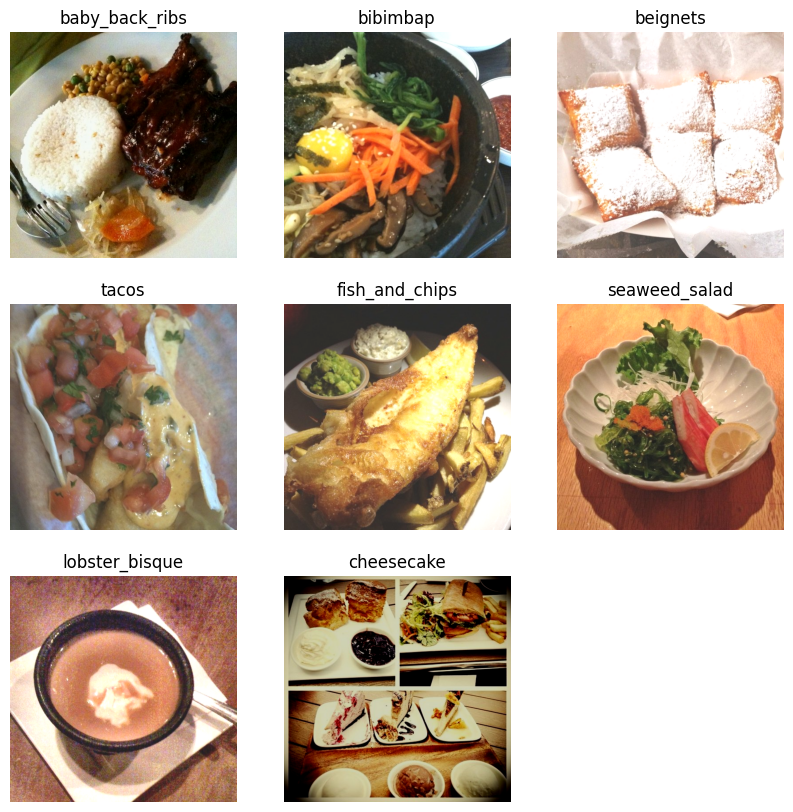

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomBrightness(factor=0.3, value_range=(0, 255))(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

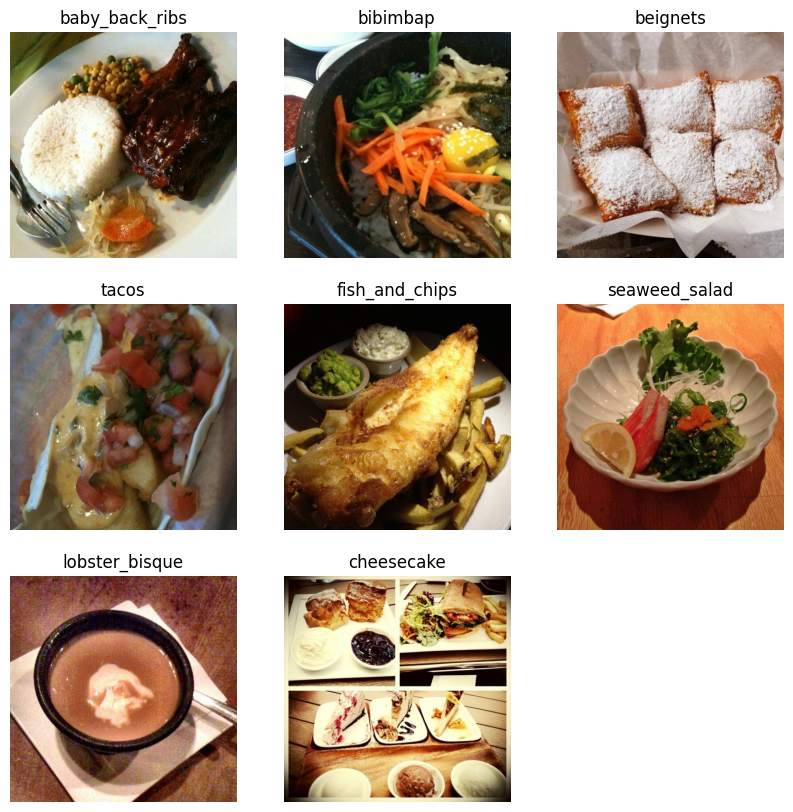

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomFlip("horizontal")(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

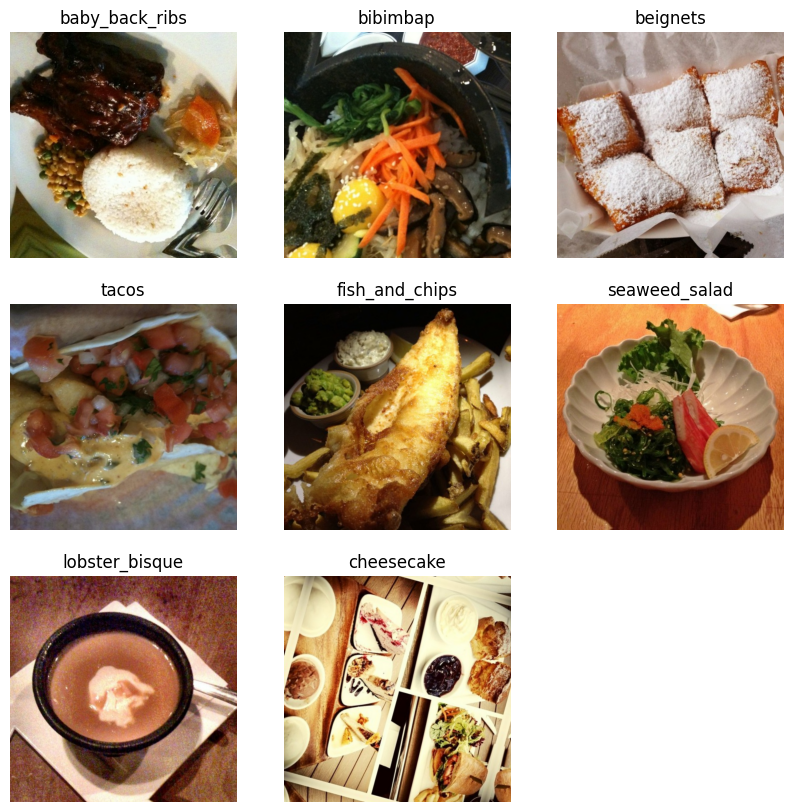

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomRotation(0.3)(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomBrightness(factor=0.3, value_range=(0, 255)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
    ]
)

resize_layer = layers.Resizing(*IMAGE_SIZE)

train_ds = train_ds.map(
    lambda img, label: (resize_layer(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds = val_ds.map(
    lambda img, label: (resize_layer(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)


train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [32]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)


    x = layers.Rescaling(1.0 / 255)(inputs)
    backbone = tf.keras.applications.InceptionV3(
        include_top=False,
        weights="imagenet"
    )
    x = backbone(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu",
                      kernel_regularizer=regularizers.L1(L1_LAMBDA),
                      activity_regularizer=regularizers.L2(L2_LAMBDA))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=101)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
model = tf.keras.models.load_model("/content/drive/MyDrive/course/cps/old_save_at_26.keras")

ValueError: File not found: filepath=/content/drive/MyDrive/course/cps/old_save_at_26.keras. Please ensure the file is an accessible `.keras` zip file.